In [1]:
import numpy as np

NEG = -1e12  # numerical -inf


class TSPHypercubeBCJR_SOVA:
    """
    PDF 원래 식 기반으로 다시 정리한 BCJR + SOVA 버전.

    - 단일 trellis ψ[t, mask, last]만 사용 (with-β)
    - α_t(a)는 항상 ψ_{t-1}에서 직접 계산:
        α_t(a) = max_{m_{t-1}, last ∈ m_{t-1}}
                    [ ψ_{t-1}(m_{t-1}, last) + s(last, a) ]
      (여기에는 β_t는 안 들어가고, 과거 시점 ≤ t-1의 β 정보만 포함)
    - trellis → X_{it} 메시지:
        ζ_{it}(a) = α_t(a) + β_t(a) - λ_{it}(a)
      (∑_{i'≠i} λ_{i't}(a) = β_t(a) - λ_{it}(a) 사용한 형태)
    - ψ는 with-β forward trellis:
        ψ_t(m_t, a_t) = max_{m_{t-1}, a_{t-1}}
            [ ψ_{t-1}(m_{t-1}, a_{t-1}) + s(a_{t-1}, a_t) + β_t(a_t) ]
      (코드에서는 t=1..T, β_t(a_t)를 beta[t-1, a_t]에 매핑)
    - BCJR backward bwd[t, mask, last]와 함께
      Γ_t(m_t,last) = ψ_t(m_t,last) + bwd_t(m_t,last)로 SOVA LLR 계산.
    """

    def __init__(self, D, start_city=None,
                 damping=0.3, iters=200, verbose=False,
                 tiny_tiebreak=False, seed=0,
                 patience_no_cost_change=10, cost_tol=1e-12,
                 kappa_bcjr=1.0,
                 damp_L=0.5, damp_beta=0.5, damp_zeta=0.5):

        D = np.array(D, dtype=float)
        assert D.shape[0] == D.shape[1], "D must be square"
        C = D.shape[0]

        if start_city is None:
            start_city = 0
        start_city = int(start_city)
        assert 0 <= start_city < C

        # permute: start -> last (internal depot)
        perm = np.arange(C)
        if start_city != C - 1:
            perm[start_city], perm[C - 1] = perm[C - 1], perm[start_city]
        inv_perm = np.empty(C, dtype=int)
        inv_perm[perm] = np.arange(C)

        self.orig_D = D
        self.D = D[perm][:, perm]
        self.perm = perm
        self.inv_perm = inv_perm

        self.C = C
        self.N = C - 1
        self.depot = C - 1

        self.verbose = verbose
        self.damp = float(damping)
        self.iters = int(iters)
        self.tiny_tiebreak = bool(tiny_tiebreak)
        self.rng = np.random.default_rng(seed)
        self.patience_no_cost_change = int(patience_no_cost_change)
        self.cost_tol = float(cost_tol)

        # BCJR / SOVA 관련 파라미터
        self.kappa_bcjr = float(kappa_bcjr)
        self.damp_L = float(damp_L)
        self.damp_beta = float(damp_beta)
        self.damp_zeta = float(damp_zeta)

        # similarity (bigger is better)
        mx = np.max(self.D)
        self.s = mx - self.D

        # trellis 크기
        self.T = self.N
        self.M = 1 << self.N

        # 단일 forward trellis ψ (with-β)
        self.psi = np.full((self.T + 1, self.M, self.N), NEG)
        self.backptr = np.full((self.T + 1, self.M, self.N, 2), -1, dtype=int)

        # backward trellis (with-β, closure 포함)
        self.bwd_wb = np.full((self.T + 1, self.M, self.N), NEG)

        # α_t(a): ψ_{t-1}로부터 계산
        self.alpha = np.full((self.T, self.N), NEG)

        # simplified messages
        self.gamma_tilde = np.zeros((self.N, self.T))
        self.omega_tilde = np.zeros((self.N, self.T))
        self.phi_tilde   = np.zeros((self.N, self.T))
        self.eta_tilde   = np.zeros((self.N, self.T))
        self.rho_tilde   = np.zeros((self.N, self.T))
        self.delta_tilde = np.zeros((self.N, self.T))

        # λ_t(i,a), ζ_t(i,a), β_t(a)
        self.lambda_ = np.zeros((self.T, self.N, self.N))
        self.zeta    = np.zeros((self.T, self.N, self.N))
        self.beta    = np.zeros((self.T, self.N))

        # damping 캐시
        self._L_prev    = [np.zeros((self.N, self.N)) for _ in range(self.T)]
        self._beta_prev = [np.zeros(self.N)            for _ in range(self.T)]
        self._zeta_prev = [np.zeros((self.N, self.N)) for _ in range(self.T)]

    # ===================== Public =====================
    def run(self):
        stable = 0
        last_cost = None
        best_route, best_cost = None, None

        for it in range(self.iters):
            # (1) forward trellis & α
            self._trellis_forward_and_alpha()

            # (2) backward trellis (primal with β + closure)
            self._trellis_backward_bcjr()

            # (3) BCJR-style SOVA LLR 계산 (T x N)
            llr_t = self._compute_sova_llr_from_bcjr()

            # (4) 메시지 업데이트
            self._update_phi_eta_rho()
            self._update_lambda_beta_zeta_delta(
                kappa=self.kappa_bcjr,
                llr_t=llr_t,
                damp_L=self.damp_L,
                damp_beta=self.damp_beta,
                damp_zeta=self.damp_zeta,
            )
            self._update_gamma_omega()

            if self.tiny_tiebreak:
                self.gamma_tilde += 1e-12 * self.rng.standard_normal(self.gamma_tilde.shape)

            # (5) route & cost
            route = self.estimate_route()
            cost = self._route_cost(route)

            if self.verbose:
                print(f"[{it+1:03d}] cost={cost:.12f} route={route}")

            # best primal 추적
            if best_cost is None or cost < best_cost:
                best_cost, best_route = cost, route

            # plateau early stop
            if last_cost is not None and abs(cost - last_cost) <= self.cost_tol:
                stable += 1
            else:
                stable = 0
            last_cost = cost

            if stable >= self.patience_no_cost_change:
                return best_route, best_cost

        return best_route, best_cost

    # ===================== Trellis (single ψ) & α =====================
    def _trellis_forward_and_alpha(self):
        """
        ψ_t(m_t, last) : with-β forward metric
        α_t(a)         : ψ_{t-1}로부터 계산 (현재 시점 β_t는 포함되지 않음)
        """
        self.psi.fill(NEG)
        self.backptr.fill(-1)
        self.alpha.fill(NEG)

        # t = 1
        # α_1(a) = s(depot, a)
        # ψ_1(m={a}, a) = s(depot, a) + β_1(a)
        for a in range(self.N):
            m = 1 << a
            gain = self.s[self.depot, a]
            self.alpha[0, a] = gain                    # α_1(a)
            self.psi[1, m, a] = gain + self.beta[0, a]  # ψ_1
            self.backptr[1, m, a] = (0, -1)             # 센티넬

        # t = 2..T
        full_mask = (1 << self.N) - 1
        for t in range(2, self.T + 1):
            # 1) α_t(a) 계산: ψ_{t-1}에서 오는 factor→A_t 메시지
            #    α_t(a) = max_{m_{t-1},last∈m_{t-1}, a∉m_{t-1}}
            #                 [ ψ_{t-1}(m_{t-1},last) + s(last,a) ]
            for a in range(self.N):
                best_alpha = NEG
                for mask in range(self.M):
                    if mask == 0 or mask.bit_count() != (t - 1):
                        continue
                    if mask & (1 << a):
                        continue  # 아직 방문 안 한 도시만
                    m = mask
                    while m:
                        last = (m & -m).bit_length() - 1
                        m ^= (1 << last)
                        cand = self.psi[t - 1, mask, last] + self.s[last, a]
                        if cand > best_alpha:
                            best_alpha = cand
                self.alpha[t - 1, a] = best_alpha

            # 2) ψ_t 전이 (with-β)
            for mask in range(self.M):
                if mask == 0 or mask.bit_count() != (t - 1):
                    continue
                for a in range(self.N):
                    if mask & (1 << a):
                        continue
                    new_mask = mask | (1 << a)
                    best = NEG
                    best_last = -1

                    m = mask
                    while m:
                        last = (m & -m).bit_length() - 1
                        m ^= (1 << last)
                        if last == a:
                            continue  # self-loop 금지

                        # ψ_{t-1} + s(last,a) + β_t(a)
                        cand = self.psi[t - 1, mask, last] + self.s[last, a] + self.beta[t - 1, a]
                        if cand > best:
                            best = cand
                            best_last = last

                    if best > self.psi[t, new_mask, a]:
                        self.psi[t, new_mask, a] = best
                        self.backptr[t, new_mask, a] = (mask, best_last)

    # ===================== Backward trellis (BCJR용) =====================
    def _trellis_backward_bcjr(self):
        """
        bwd_wb[t, mask, last]:
          - t 시점에 (mask,last) 상태에서 시작해서
          - 나머지 도시 방문 + depot으로 귀환까지의 최대 future metric.
        전이:
          - t < T:
              bwd[t,mask,last] = max_{a not in mask} { s[last,a] + β_{t+1}(a) + bwd[t+1, mask|{a}, a] }
            (코드에선 β_{t+1}(a)를 beta[t, a]로 저장)
          - t = T:
              full_mask 에 대해서만 closure: s[last, depot]
        """
        self.bwd_wb.fill(NEG)
        full_mask = (1 << self.N) - 1

        # t = T: full mask에서 depot으로 가는 closure
        t = self.T
        for last in range(self.N):
            mask = full_mask
            self.bwd_wb[t, mask, last] = self.s[last, self.depot]

        # t = T-1..1 역순
        for t in range(self.T - 1, 0, -1):
            for mask in range(self.M):
                if mask == 0 or mask.bit_count() != t:
                    continue
                for last in range(self.N):
                    if not (mask & (1 << last)):
                        continue

                    best = NEG
                    avail = (~mask) & full_mask
                    m = avail
                    while m:
                        a = (m & -m).bit_length() - 1
                        m ^= (1 << a)
                        new_mask = mask | (1 << a)
                        cand = self.s[last, a] + self.beta[t, a] + self.bwd_wb[t + 1, new_mask, a]
                        if cand > best:
                            best = cand
                    self.bwd_wb[t, mask, last] = best

    # ===================== SOVA-style LLR from BCJR =====================
    def _compute_sova_llr_from_bcjr(self):
        """
        llr[t, i] ≈
          max_{mask, last=i, |mask|=t+1} [ ψ[t+1, mask, i] + bwd[t+1, mask, i] ]
          - max_{mask, last≠i, |mask|=t+1} [ ψ[t+1, mask, last] + bwd[t+1, mask, last] ]
        여기서 내부 시간 인덱스(t+1)는 1..T 와 매칭, 외부 t는 0..T-1.
        """
        T, N, M = self.T, self.N, self.M
        llr = np.zeros((T, N), dtype=float)

        for t in range(1, T + 1):  # 내부 시간: 1..T
            for i in range(N):
                best_with = NEG
                best_without = NEG

                for mask in range(M):
                    if mask == 0 or mask.bit_count() != t:
                        continue

                    # last = i 인 state
                    val_i = self.psi[t, mask, i] + self.bwd_wb[t, mask, i]
                    if val_i > best_with:
                        best_with = val_i

                    # last ≠ i 인 state들 중 최고값
                    m2 = mask
                    while m2:
                        last = (m2 & -m2).bit_length() - 1
                        m2 ^= (1 << last)
                        if last == i:
                            continue
                        val = self.psi[t, mask, last] + self.bwd_wb[t, mask, last]
                        if val > best_without:
                            best_without = val

                if best_with <= NEG / 2 and best_without <= NEG / 2:
                    llr[t - 1, i] = 0.0
                else:
                    llr[t - 1, i] = best_with - best_without

        return llr

    # ===================== Messages =====================
    def _update_phi_eta_rho(self):
        # φ̃_it = -max_{i'≠i} γ̃_i't
        for t in range(self.T):
            col = self.gamma_tilde[:, t]
            for i in range(self.N):
                self.phi_tilde[i, t] = -np.max(np.delete(col, i)) if self.N > 1 else 0.0
        # η̃_it = -max_{t'≠t} ω̃_it'
        for i in range(self.N):
            row = self.omega_tilde[i, :]
            for t in range(self.T):
                self.eta_tilde[i, t] = -np.max(np.delete(row, t)) if self.T > 1 else 0.0
        # ρ̃_it
        self.rho_tilde = self.eta_tilde + self.phi_tilde

    def _update_lambda_beta_zeta_delta(self, kappa=0.0, llr_t=None,
                                       damp_L=0.5, damp_beta=0.5, damp_zeta=0.5):
        T, N = self.T, self.N

        for t in range(T):
            # (1) rhõ -> (rho0, rho1) 복원
            r = self.rho_tilde[:, t]  # shape (N,)
            rho0 = -r / N             # off-diagonal
            rho1 = rho0 + r           # diagonal

            # (2) L_new(i,a): a==i→rho1, else→rho0
            L_new = np.empty((N, N), float)
            for i in range(N):
                L_new[i, :] = rho0[i]
                L_new[i, i] = rho1[i]

            # (3) λ 이중 센터링
            L_new -= L_new.mean(axis=1, keepdims=True)
            L_new -= L_new.mean(axis=0, keepdims=True)

            # (4) λ damping
            L_prev = self._L_prev[t]
            L = damp_L * L_new + (1 - damp_L) * L_prev
            self.lambda_[t] = L

            # (5) β_t(a) = sum_i λ_{it}(a)
            beta_new = L.sum(axis=0)
            beta_new -= beta_new.mean()

            # (6) β damping
            beta_prev = self._beta_prev[t]
            beta_t = damp_beta * beta_new + (1 - damp_beta) * beta_prev
            self.beta[t, :] = beta_t

            # (7) ζ_it(a) = α_t(a) + β_t(a) - λ_it(a)
            a_t = self.alpha[t, :]
            Z_new = a_t[np.newaxis, :] + beta_t[np.newaxis, :] - L

            # (8) SOVA LLR 주입 (대각 성분)
            if kappa and llr_t is not None:
                for i in range(N):
                    Z_new[i, i] += kappa * llr_t[t, i]

            # (9) ζ damping
            Z_prev = self._zeta_prev[t]
            Z = damp_zeta * Z_new + (1 - damp_zeta) * Z_prev
            self.zeta[t] = Z

            # (10) δ̃_it = ζ_it(i) - max_{a≠i} ζ_it(a)
            for i in range(N):
                zi = Z[i, :]
                self.delta_tilde[i, t] = 0.0 if N == 1 else (zi[i] - np.max(np.delete(zi, i)))

        # 캐시 갱신
        self._L_prev    = [self.lambda_[t].copy() for t in range(T)]
        self._beta_prev = [self.beta[t].copy()    for t in range(T)]
        self._zeta_prev = [self.zeta[t].copy()    for t in range(T)]

    def _update_gamma_omega(self):
        gamma_new = self.eta_tilde + self.delta_tilde
        omega_new = self.phi_tilde + self.delta_tilde
        self.gamma_tilde = self.damp * gamma_new + (1 - self.damp) * self.gamma_tilde
        self.omega_tilde = self.damp * omega_new + (1 - self.damp) * self.omega_tilde

    # ===================== Decode =====================
    def estimate_route(self):
        full_mask = (1 << self.N) - 1
        best_val = NEG
        best_last = -1

        for last in range(self.N):
            base = self.psi[self.T, full_mask, last]
            if base <= NEG / 2:
                continue
            val = base + self.s[last, self.depot]  # closure
            if val > best_val:
                best_val = val
                best_last = last

        # backtrack
        if best_last < 0:
            # fallback: α 기반 greedy
            route_internal = [self.depot]
            used = set()
            for t in range(self.T):
                sc = self.alpha[t].copy()
                for u in used:
                    sc[u] = NEG
                if self.tiny_tiebreak:
                    sc += 1e-15 * np.arange(self.N)
                a = int(np.argmax(sc))
                used.add(a)
                route_internal.append(a)
            route_internal.append(self.depot)
        else:
            route_inner = []
            mask = full_mask
            last = best_last
            t = self.T
            while t > 0 and 0 <= last < self.N:
                route_inner.append(last)
                prev_mask, prev_last = self.backptr[t, mask, last]
                mask, last = prev_mask, prev_last
                t -= 1
            route_inner.reverse()
            route_internal = [self.depot] + route_inner + [self.depot]

        return [int(self.inv_perm[c]) for c in route_internal]

    def _route_cost(self, route):
        return float(sum(self.orig_D[route[k], route[k + 1]] for k in range(len(route) - 1)))


In [2]:
import numpy as np

class TSPBitmask:
    def __init__(self, dist, max=50, verbose=False):
        self.dist = dist
        self.verbose = verbose
        self.n = dist.shape[0]
        self.dp = {}
        self.tour = []
        self.min_cost = np.inf
        self.max = max

    def run(self):
        n = self.n
        cities = list(range(n - 1))  # exclude depot

        dp = {}  # (visited_mask, current_city) → (cost, prev_city)

        # Initialize: depot → i
        for i in cities:
            dp[(1 << i, i)] = (self.dist[n - 1][i], n - 1)

        for visited in range(1 << (n - 1)):
            for u in cities:
                if not (visited & (1 << u)):
                    continue
                for v in cities:
                    if visited & (1 << v):
                        continue
                    if self.dist[u][v] >= self.max:
                        continue
                    new_visited = visited | (1 << v)
                    prev_cost = dp.get((visited, u), (np.inf, -1))[0]
                    new_cost = prev_cost + self.dist[u][v]
                    if (new_visited, v) not in dp or new_cost < dp[(new_visited, v)][0]:
                        dp[(new_visited, v)] = (new_cost, u)

        end_mask = (1 << (n - 1)) - 1
        min_cost = np.inf
        last_city = -1
        for u in cities:
            cost_to_depot = dp.get((end_mask, u), (np.inf, -1))[0] + self.dist[u][n - 1]
            if cost_to_depot < min_cost:
                min_cost = cost_to_depot
                last_city = u

        # Reconstruct path
        tour = [n - 1]  # start from depot
        mask = end_mask
        curr = last_city
        for _ in range(n - 1):
            tour.append(curr)
            mask, curr = mask ^ (1 << curr), dp[(mask, curr)][1]
        tour.append(n - 1)
        tour.reverse()

        self.dp = dp
        self.tour = tour
        self.min_cost = min_cost

        if self.verbose:
            print(f"Tour (1-based): {[x+1 for x in tour]}")
            print(f"Total Cost: {min_cost:.4f}")

        return tour, min_cost

    def get_path(self):
        return self.tour

    def get_cost(self):
        return self.min_cost

In [10]:
N = 14
d = np.random.rand(N,N)
import time

start_time1 = time.time()
solver_1 = TSPBitmask(d, verbose=False)
path1, cost1 = solver_1.run()
end_time1 = time.time()
print(path1, cost1, end_time1-start_time1)

start_time2 = time.time()
solver_2 = TSPHypercubeSimplified_PatchA(d, iters=200, start_city=N-1, verbose=False)
path2, cost2 = solver_2.run()
end_time2 = time.time()
print(path2, cost2, end_time2-start_time2)

start_time3 = time.time()
solver_3 = TSPHypercubeBCJR_SOVA(d, iters=200, start_city=N-1, verbose=False)
path3, cost3 = solver_3.run()
end_time3 = time.time()
print(path3, cost3, end_time3-start_time3)

[13, 0, 11, 5, 4, 3, 8, 7, 2, 6, 9, 1, 10, 12, 13] 1.5541694438785765 0.4873008728027344
[13, 0, 11, 5, 4, 3, 8, 7, 2, 6, 9, 1, 10, 12, 13] 1.5541694438785765 8.418556213378906
[13, 0, 11, 5, 4, 3, 8, 7, 2, 6, 9, 1, 10, 12, 13] 1.5541694438785765 18.299875736236572


[[   0.   1134.71  779.76 1132.89  922.69  519.3   309.69 1052.6   938.16
   621.82  522.1   858.36 1167.38 1046.9 ]
 [1134.71    0.    387.76  167.2   292.03  724.17 1034.7   342.79  579.22
   923.35 1222.99  822.1   670.88  830.54]
 [ 779.76  387.76    0.    353.55  145.23  336.49  648.36  300.67  350.96
   554.48  838.14  520.69  558.49  605.6 ]
 [1132.89  167.2   353.55    0.    216.08  670.69  988.92  190.26  441.56
   830.81 1148.33  694.35  506.66  679.82]
 [ 922.69  292.03  145.23  216.08    0.    455.21  773.18  168.63  313.21
   632.89  940.56  538.01  474.43  576.18]
 [ 519.3   724.17  336.49  670.69  455.21    0.    318.4   552.73  419.45
   271.86  505.6   394.65  651.71  564.9 ]
 [ 309.69 1034.7   648.36  988.92  773.18  318.4     0.    866.83  698.87
   319.92  267.44  570.35  911.44  760.89]
 [1052.6   342.79  300.67  190.26  168.63  552.73  866.83    0.    254.01
   668.92  996.61  509.26  335.17  490.35]
 [ 938.16  579.22  350.96  441.56  313.21  419.45  698.87  254.0

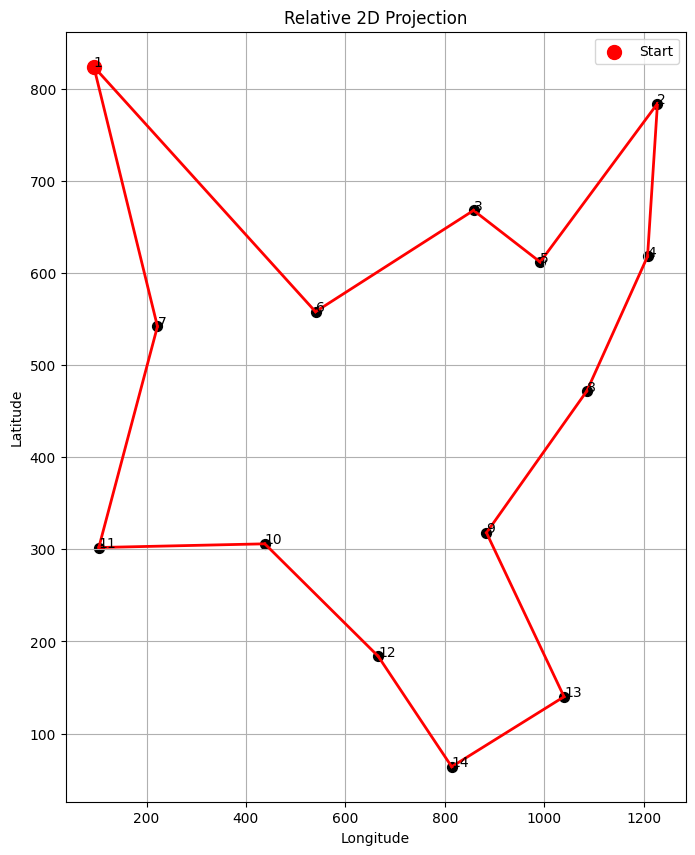

In [17]:
import matplotlib.pyplot as plt
'''
cities = [
    "Seoul", "Busan", "Daegu", "Daejeon", "Gwangju", 
    "Incheon", "Suwon", "Gangneung", "Mokpo", "Yeosu",
    "Cheonan", "Wonju", "Dangjin"
]
# 각 도시의 (경도, 위도)
coords = np.array([
    [126.9780, 37.5665],  # 서울
    [129.0756, 35.1796],  # 부산
    [128.6014, 35.8714],  # 대구
    [127.3850, 36.3510],  # 대전
    [126.8514, 35.1600],  # 광주
    [126.7052, 37.4563],  # 인천
    [127.0182, 37.2636],  # 수원
    [128.8961, 37.7519],  # 강릉
    [126.3922, 34.8118],  # 목포
    [127.6622, 34.7604],  # 여수
    [127.1522, 36.8151],  # 천안
    [127.9453, 37.3422],  # 원주
    [126.6290, 36.8943],  # 당진
])'''

coords = np.array([
    (94.0, 824.0),
    (1228.0, 784.0),
    (858.0, 668.0),
    (1208.0, 618.0),
    (992.0, 612.0),
    (540.0, 558.0),
    (222.0, 542.0),
    (1086.0, 472.0),
    (884.0, 318.0),
    (438.0, 306.0),
    (104.0, 302.0),
    (666.0, 184.0),
    (1040.0, 140.0),
    (814.0, 64.0)
], dtype=float)
# 번호는 1~14로 부여
indices = np.arange(1, 15)
N = len(coords)
dist = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        dist[i, j] = np.linalg.norm(coords[i] - coords[j])
np.set_printoptions(precision=2, suppress=True)
#print(dist)

solver = TSPHypercubeBCJR_SOVA(dist, verbose=False)
path4, cost4 = solver.run()
print(path4, cost4)

def plot_cities_and_path(coords, cities, path):
    fig, ax = plt.subplots(figsize=(8, 10))

    x = coords[:, 0]
    y = coords[:, 1]

    # 도시 점 찍기
    ax.scatter(x, y, c='black', s=50)

    # 도시 이름 표시
    for i, name in enumerate(cities):
        ax.text(x[i] + 0.03, y[i] + 0.03, name, fontsize=10)

    # path 이동 경로 빨간 선으로
    for i in range(len(path) - 1):
        a = path[i]
        b = path[i + 1]
        ax.plot([x[a], x[b]], [y[a], y[b]], 'r-', linewidth=2)

    # 시작점 강조
    ax.scatter(x[path[0]], y[path[0]], c='red', s=100, label="Start")

    ax.set_title("Relative 2D Projection")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    plt.legend()
    plt.show()


# 실행
plot_cities_and_path(coords, indices, path4)


In [ ]:
import numpy as np
####### Relaxation method, 의외로 잘 되는듯, 속도는 빠른데 최적은 어림도 없음########
class TSP_PDF_Solver:
    def __init__(self, dist_matrix, damping=0.5, verbose=True):
        """
        :param dist_matrix: N x N 거리 행렬
        :param damping: Lambda 업데이트 시 진동을 막기 위한 Damping factor (0 < damping <= 1)
        :param verbose: 디버그 출력 여부
        """
        self.dist = dist_matrix
        self.N = dist_matrix.shape[0]
        self.damping = damping
        self.verbose = verbose
        
        # PDF Eq 모델에 따른 변수 초기화
        # lambda_t(i): Time t에 City i를 방문하는 것에 대한 Lagrange Multiplier
        self.lam = np.zeros((self.N, self.N)) 

    def solve(self, max_iter=100):
        best_path = None
        best_cost = float('inf')

        for it in range(max_iter):
            # 1. Trellis 구성 (Alpha, Beta 계산)
            # G_t(x_{t-1}, x_t) + lambda_t(x_t) 형태의 에너지를 기반으로 함
            alpha = self._run_forward_alpha()
            beta = self._run_backward_beta()

            # 2. Soft Output (LLR) delta_tilde 계산 [Fix 2 & 3 반영]
            # PDF Eq (3.6)에 따라 순수 Posterior Ratio 계산
            delta_tilde = self._compute_soft_output(alpha, beta)

            # 3. 최적 경로 추출 (MAP 추정)
            current_path, current_cost = self._decode_path(delta_tilde)

            # 4. 결과 모니터링
            if current_cost < best_cost:
                best_cost = current_cost
                best_path = current_path
                if self.verbose:
                    print(f"[Iter {it}] New Best Cost: {best_cost:.4f} (Valid Path)")
            else:
                if self.verbose:
                    print(f"[Iter {it}] Cost: {current_cost:.4f}")

            # 5. Lambda 업데이트 [Fix 1 반영]
            # PDF Eq (1.2): 대각 성분은 빼고, 비대각 성분은 더함
            update_term = self._compute_lambda_update(delta_tilde)
            
            # Damping 적용하여 업데이트
            self.lam = self.lam + self.damping * update_term

        return best_path, best_cost

    def _get_edge_weight(self, t, u, v):
        """
        Trellis 간선 가중치 계산
        W_t(u, v) = -Distance(u, v) + Lambda_t(v)
        * PDF 모델에서는 에너지를 최대화(Max-Sum)하는 관점이므로 거리에 마이너스 부호
        """
        # t 시점에서 u -> v 로 갈 때의 가중치
        # lambda는 '도착 노드 v'가 시간 t에 할당되는 제약 조건과 관련됨 (혹은 t+1, 구현에 따라 정의)
        # 여기서는 Time t (도착시간)에 City v를 방문하는 비용으로 정의
        return -self.dist[u, v] + self.lam[t, v]

    def _run_forward_alpha(self):
        """
        Forward Pass (Alpha)
        alpha[t, v] = max_u ( alpha[t-1, u] + Weight(u, v) )
        """
        alpha = np.full((self.N, self.N), -np.inf)
        
        # t=0 초기화 (첫 도시는 0번 도시로 고정 가정, 혹은 Start Node 처리)
        # 일반적으로 TSP는 0번 노드에서 시작한다고 가정
        alpha[0, 0] = 0 
        
        for t in range(1, self.N):
            for v in range(self.N): # 현재 노드 (t)
                scores = []
                for u in range(self.N): # 이전 노드 (t-1)
                    if alpha[t-1, u] == -np.inf: continue
                    # 가중치: u -> v 로 이동하며 t 시점에 v에 도착
                    weight = self._get_edge_weight(t, u, v)
                    scores.append(alpha[t-1, u] + weight)
                
                if scores:
                    alpha[t, v] = np.max(scores)
        
        return alpha

    def _run_backward_beta(self):
        """
        Backward Pass (Beta) [Fix 3: Backward Definition Strictness]
        PDF Eq: beta_t(u) = max_v ( G_{t+1}(u, v) + beta_{t+1}(v) )
        * 중요: beta는 '현재 상태 u'에서 '미래의 최대 이득'을 담음.
        * t 시점의 lambda는 이미 Alpha 혹은 Edge Weight에 포함되므로 중복 사용 주의.
        """
        beta = np.full((self.N, self.N), -np.inf)
        
        # 마지막 단계 (Return to Start) 처리
        # t=N-1 (마지막 도시) -> t=N (다시 0번 도시)
        for u in range(self.N):
            # 마지막에서 시작점으로 돌아오는 비용 (Cyclic TSP)
            # 여기서는 t=0 의 lambda를 다시 더하지 않음 (보통 Loop Closing은 거리만 고려)
            beta[self.N-1, u] = -self.dist[u, 0] 

        # t = N-2 부터 0 까지 역방향 진행
        for t in range(self.N - 2, -1, -1):
            for u in range(self.N): # 현재 노드 (t)
                scores = []
                for v in range(self.N): # 다음 노드 (t+1)
                    # 다음 노드 v로 가는 가중치 (t+1 시점의 lambda 포함)
                    weight = self._get_edge_weight(t+1, u, v)
                    
                    if beta[t+1, v] != -np.inf:
                        scores.append(weight + beta[t+1, v])
                
                if scores:
                    beta[t, u] = np.max(scores)
                    
        return beta

    def _compute_soft_output(self, alpha, beta):
        """
        [Fix 2] Soft Output (LLR) delta_tilde 계산
        PDF Eq (3.6): delta(i) = Max(x in X_i) - Max(x not in X_i)
        * 임의로 lambda를 빼거나 더하지 않음.
        * 오직 Trellis Score (Alpha + Beta) 만을 사용.
        """
        delta_tilde = np.zeros((self.N, self.N))
        
        # Total Score Matrix: S[t, i] = alpha[t, i] + beta[t, i]
        # 이 값은 (t, i)를 반드시 지나는 경로 중 최대 Score를 의미함
        total_scores = alpha + beta
        
        for t in range(self.N):
            # t 시점의 모든 노드에 대한 Score
            row_scores = total_scores[t, :]
            
            # Global Max at time t (해당 시점에서 가장 유력한 경로의 점수)
            # 주의: Max(x not in X_i)를 구하기 위해, i를 제외한 나머지 중 Max를 찾아야 함
            
            # 효율적인 계산을 위해 미리 정렬하거나 마스킹 사용
            for i in range(self.N):
                score_in = row_scores[i]
                
                # i를 제외한 나머지 노드들의 점수 중 최대값
                # mask를 씌워서 max 계산
                other_scores = np.delete(row_scores, i)
                score_out = np.max(other_scores) if len(other_scores) > 0 else -np.inf
                
                # Eq 3.6 정의 준수
                delta_tilde[t, i] = score_in - score_out
                
        return delta_tilde

    def _compute_lambda_update(self, delta_tilde):
        """
        [Fix 1] Lambda Bias Update
        PDF Eq (1.2): lambda_t(i) 업데이트 텀 계산
        Formula: -rho(i, i) + sum_{j != i} rho(i, j)
        여기서 rho는 delta_tilde (Soft Output)를 의미
        """
        update_matrix = np.zeros_like(delta_tilde)
        
        for t in range(self.N):
            # t 시점의 delta_tilde 벡터
            rho_vec = delta_tilde[t, :]
            
            sum_rho = np.sum(rho_vec) # sum_{all j} rho(i, j)
            
            for i in range(self.N):
                # sum_{j != i} rho = (Total Sum) - rho(i)
                sum_others = sum_rho - rho_vec[i]
                
                # 식 적용: -rho(i) + sum_others
                update_matrix[t, i] = -rho_vec[i] + sum_others
                
        return update_matrix

    def _decode_path(self, delta_tilde):
        """
        delta_tilde 값을 기반으로 가장 유력한 경로를 Greedy하게 선택하거나
        단순히 Argmax를 취함 (여기서는 LLR이 가장 큰 순서대로 선택하되 방문 제약 고려)
        """
        path = [-1] * self.N
        visited = [False] * self.N
        
        # 간단한 Greedy Decoding: 각 시간 t마다 LLR이 가장 큰 도시 선택 (충돌 회피)
        # 실제로는 Trellis Backtracking이 더 정확하지만, Iteration 모니터링 용도
        
        # 0번 도시는 0번 타임 고정
        path[0] = 0
        visited[0] = True
        
        cost = 0
        
        for t in range(1, self.N):
            best_node = -1
            best_val = -np.inf
            
            for i in range(self.N):
                if not visited[i]:
                    if delta_tilde[t, i] > best_val:
                        best_val = delta_tilde[t, i]
                        best_node = i
            
            if best_node != -1:
                path[t] = best_node
                visited[best_node] = True
                cost += self.dist[path[t-1], path[t]]
        
        # Return to start cost
        if -1 not in path:
            cost += self.dist[path[-1], path[0]]
            return path, cost
        else:
            return path, float('inf')

# --- 실행 예시 ---
if __name__ == "__main__":
    # 간단한 5도시 예제 (대칭)
    N = 10
    coords = np.random.rand(N, 2) * 10
    dist_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])

    # Solver 실행
    solver = TSP_PDF_Solver(dist_matrix, damping=0.5, verbose=True)
    best_path, best_cost = solver.solve(max_iter=100)
    
    print("\nFinal Solution Path:", best_path)
    print("Final Cost:", best_cost)
    
    solver2 = TSPBitmask(dist_matrix)
    path2, cost2 = solver2.run()
    print("\nBitmask Solution Path:", path2)
    print("Bitmask Cost:", cost2)

[Iter 0] New Best Cost: 57.3547 (Valid Path)
[Iter 1] Cost: 61.5082
[Iter 2] New Best Cost: 56.6872 (Valid Path)
[Iter 3] New Best Cost: 42.3037 (Valid Path)
[Iter 4] Cost: 45.7615
[Iter 5] New Best Cost: 35.3867 (Valid Path)
[Iter 6] New Best Cost: 34.4768 (Valid Path)
[Iter 7] New Best Cost: 34.4768 (Valid Path)
[Iter 8] Cost: 34.4768
[Iter 9] Cost: 34.4768
[Iter 10] Cost: 34.4768
[Iter 11] Cost: 34.4768
[Iter 12] Cost: 34.4768
[Iter 13] Cost: 34.4768
[Iter 14] Cost: 34.4768
[Iter 15] Cost: 34.4768
[Iter 16] Cost: 34.4768
[Iter 17] Cost: 34.4768
[Iter 18] Cost: 34.4768
[Iter 19] Cost: 34.4768
[Iter 20] Cost: 34.4768
[Iter 21] Cost: 34.4768
[Iter 22] Cost: 34.4768
[Iter 23] Cost: 34.4768
[Iter 24] Cost: 34.4768
[Iter 25] Cost: 34.4768
[Iter 26] Cost: 34.4768
[Iter 27] Cost: 34.4768
[Iter 28] Cost: 34.4768
[Iter 29] Cost: 34.4768
[Iter 30] Cost: 34.4768
[Iter 31] Cost: 34.4768
[Iter 32] Cost: 34.4768
[Iter 33] Cost: 34.4768
[Iter 34] Cost: 34.4768
[Iter 35] Cost: 34.4768
[Iter 36] Cost

In [83]:
import numpy as np
from collections import defaultdict

INF = 1e12 
#####진짜 제일 잘되는 애는 얘######### LLR 이중으로 들어감
class TSPSolverLLRFeedback:
    def __init__(self, dist_matrix, bp_iterations=50, damping=0.7, 
                 scaling_factor=0.01, feedback_strength=0.5, verbose=True):
        """
        scaling_factor (0.01): 제약 조건(Lambda)을 얼마나 반영할지 (작을수록 간섭 줄임)
        feedback_strength (0.5): LLR(자기확신)을 얼마나 반영할지 (클수록 한번 찾은 길 고정)
        """
        self.dist_matrix = np.array(dist_matrix)
        self.num_nodes = self.dist_matrix.shape[0]
        self.N = self.num_nodes - 1
        self.depot = self.N
        self.bp_iterations = bp_iterations
        self.damping = damping
        self.verbose = verbose
        
        # 파라미터 저장
        self.scaling_factor = scaling_factor
        self.feedback_strength = feedback_strength
        
        # S 행렬 (대각성분 제거)
        max_dist = np.max(self.dist_matrix)
        self.S = max_dist - self.dist_matrix
        np.fill_diagonal(self.S, -INF) 
        
        # Messages
        self.tilde_rho = np.zeros((self.N, self.N))
        self.tilde_eta = np.zeros((self.N, self.N))
        self.tilde_phi = np.zeros((self.N, self.N))
        
        # [핵심] 이전 이터레이션의 LLR(tilde_delta) 저장용
        self.last_llr = np.zeros((self.N, self.N))

    def log(self, msg):
        if self.verbose:
            print(msg)

    def _calc_total_bias(self):
        """
        [수정된 Bias 계산]
        Bias = (Constraint Bias * Scaling) + (LLR Feedback * Strength)
        """
        N = self.N
        
        # 1. 제약 조건에 의한 Bias (Constraint)
        # lambda_sum_bias calculation (Eq 1.2 logic)
        sum_rho_t = np.sum(self.tilde_rho, axis=1, keepdims=True)
        constraint_bias = -self.tilde_rho + ((N - 1) / N) * sum_rho_t
        
        # 2. LLR에 의한 Feedback (Reinforcement)
        # 이전 턴에서 '확률이 높다'고 판단된 경로에 가산점 부여
        llr_bias = self.last_llr
        
        # 3. 최종 Bias 결합
        # 제약 조건은 아주 약하게(scaling), 확신은 적당하게(feedback)
        total_bias = (constraint_bias * self.scaling_factor) + (llr_bias * self.feedback_strength)
        
        return total_bias

    def _run_trellis(self):
        N, S, depot = self.N, self.S, self.depot
        
        # LLR이 포함된 Bias 계산
        bias = self._calc_total_bias()
        
        # --- Forward (Alpha) ---
        alpha = [defaultdict(lambda: -INF) for _ in range(N + 1)]
        alpha[0][(0, depot)] = 0.0
        
        for t in range(N):
            current_bias = bias[t]
            for state, prev_score in alpha[t].items():
                if prev_score < -INF / 2: continue
                mask, prev_node = state
                for i in range(N):
                    if not (mask & (1 << i)):
                        new_mask = mask | (1 << i)
                        # Score = Similarity + Bias(Constraint + LLR)
                        val = prev_score + S[prev_node, i] + current_bias[i]
                        
                        if val > alpha[t+1][(new_mask, i)]:
                            alpha[t+1][(new_mask, i)] = val
                            
        # --- Backward (Beta) ---
        beta = [defaultdict(lambda: -INF) for _ in range(N + 2)]
        final_mask = (1 << N) - 1
        for i in range(N):
            beta[N][(final_mask, i)] = S[i, depot]
            
        for t in range(N - 1, -1, -1):
            for next_state, next_beta_val in beta[t+1].items():
                if next_beta_val < -INF / 2: continue
                next_mask, next_node = next_state
                prev_mask = next_mask & ~(1 << next_node)
                
                # Backward에서도 동일한 Bias 적용
                xi_val = next_beta_val + bias[t][next_node]
                
                cands = [depot] if prev_mask == 0 else [j for j in range(N) if prev_mask & (1<<j)]
                for prev in cands:
                    val = S[prev, next_node] + xi_val
                    if val > beta[t][(prev_mask, prev)]:
                        beta[t][(prev_mask, prev)] = val

        # --- Soft Output (Delta / LLR) Calculation ---
        tilde_delta = np.zeros((N, N))
        for t in range(N):
            for i in range(N):
                max_in = -INF
                max_out = -INF
                
                # Delta 계산 시에는 순수 Constraint 메시지만 빼주는 것이 논리적임
                # (Bias에 LLR이 섞여있으므로, 중복 제거를 위해 고려)
                # 하지만, 여기서는 근사적으로 Constraint 부분만 제거
                
                rho_val = self.tilde_rho[t, i] * self.scaling_factor
                lam_i_for_i = -(1.0/N) * rho_val
                lam_i_for_j = ((N-1.0)/N) * rho_val

                for state, f_score in alpha[t+1].items():
                    if f_score < -INF / 2: continue
                    if state not in beta[t+1]: continue
                    b_score = beta[t+1][state]
                    if b_score < -INF / 2: continue
                    
                    total_score = f_score + b_score
                    current_city = state[1]
                    
                    if current_city == i:
                        zeta = total_score - lam_i_for_i
                        if zeta > max_in: max_in = zeta
                    else:
                        zeta = total_score - lam_i_for_j
                        if zeta > max_out: max_out = zeta
                
                if max_in < -INF / 2: diff = -INF
                elif max_out < -INF / 2: diff = INF
                else: diff = max_in - max_out
                
                tilde_delta[t, i] = diff
        
        # [중요] 다음 턴을 위해 LLR 저장 (Feedback Loop)
        # 값이 너무 커지는 것을 막기 위해 클리핑 가능 (선택사항)
        self.last_llr = np.clip(tilde_delta, -1e5, 1e5)
                
        return alpha, tilde_delta

    def _run_bp(self, tilde_delta):
        N = self.N
        
        # BP Update (Standard)
        t_omega = self.tilde_phi + tilde_delta
        
        new_eta = np.zeros_like(self.tilde_eta)
        for i in range(N):
            for t in range(N):
                mask = np.ones(N, dtype=bool)
                mask[t] = False
                new_eta[t, i] = -np.max(t_omega[mask, i])
                
        t_gamma = new_eta + tilde_delta
        new_phi = np.zeros_like(self.tilde_phi)
        for t in range(N):
            for i in range(N):
                mask = np.ones(N, dtype=bool)
                mask[i] = False
                new_phi[t, i] = -np.max(t_gamma[t, mask])
        
        self.tilde_eta = self.damping * self.tilde_eta + (1 - self.damping) * new_eta
        self.tilde_phi = self.damping * self.tilde_phi + (1 - self.damping) * new_phi
        self.tilde_rho = self.tilde_eta + self.tilde_phi

    def _extract_path(self, alpha):
        path = []
        curr_mask = (1 << self.N) - 1
        best_score = -INF
        best_last = -1
        
        for i in range(self.N):
            state = (curr_mask, i)
            if state in alpha[self.N]:
                if alpha[self.N][state] < -INF / 2: continue
                score = alpha[self.N][state] + self.S[i, self.depot]
                if score > best_score:
                    best_score = score
                    best_last = i
        
        if best_last == -1: return [], INF
        
        path = [self.depot, best_last]
        curr_node = best_last
        
        # Traceback용 Bias도 동일하게 계산
        bias = self._calc_total_bias()
        
        for t in range(self.N - 1, 0, -1):
            prev_mask = curr_mask & ~(1 << curr_node)
            best_prev = -1
            max_val = -INF
            cands = [self.depot] if prev_mask == 0 else [j for j in range(self.N) if prev_mask & (1<<j)]
            
            current_step_bias = bias[t][curr_node]
            for prev in cands:
                state = (0, prev) if prev == self.depot else (prev_mask, prev)
                if state in alpha[t]:
                    if alpha[t][state] < -INF / 2: continue
                    val = alpha[t][state] + self.S[prev, curr_node] + current_step_bias
                    if val > max_val:
                        max_val = val
                        best_prev = prev
            path.append(best_prev)
            curr_node = best_prev
            curr_mask = prev_mask
            
        path.append(self.depot)
        path.reverse()
        cost = 0
        for k in range(len(path)-1):
            cost += self.dist_matrix[path[k], path[k+1]]
        return path, cost

    def solve(self):
        best_global_path = []
        best_global_cost = INF
        
        print(f"Solving with LLR Feedback (Constraint Scale={self.scaling_factor}, LLR Strength={self.feedback_strength})")
        
        for it in range(self.bp_iterations):
            alpha, tilde_delta = self._run_trellis()
            path, cost = self._extract_path(alpha)
            
            if cost < best_global_cost:
                best_global_cost = cost
                best_global_path = path
                print(f"[Iter {it}] Cost: {cost:.2f} (New Best!) | Lock-in Activated")
            else:
                if self.verbose:
                     print(f"[Iter {it}] Cost: {cost:.2f}")

            self._run_bp(tilde_delta)
            
        return best_global_path, best_global_cost

# --- 실행 ---
if __name__ == "__main__":
    # 데이터는 기존과 동일
    D = [
        [0, 10, 15, 20],
        [10, 0, 35, 25],
        [15, 35, 0, 30],
        [20, 25, 30, 0]
    ]
    
    D = np.random.rand(14,14) * 100
    # 1. 제약 조건 간섭 최소화 (scaling=0.01)
    # 2. 찾은 경로 강력 고정 (feedback=0.5)
    solver = TSPSolverLLRFeedback(D, bp_iterations=20, scaling_factor=0.04, feedback_strength=0.5)
    path, cost = solver.solve()
    print(f"\nFinal Result: {path}, Cost: {cost}")
    
    solver2 = TSPBitmask(D)
    path2, cost2 = solver2.run()
    print(f"\nBitmask Result: {path2}, Cost: {cost2}")

Solving with LLR Feedback (Constraint Scale=0.04, LLR Strength=0.5)
[Iter 0] Cost: 209.43 (New Best!) | Lock-in Activated
[Iter 1] Cost: 209.43
[Iter 2] Cost: 209.43
[Iter 3] Cost: 209.43
[Iter 4] Cost: 209.43
[Iter 5] Cost: 209.43
[Iter 6] Cost: 209.43
[Iter 7] Cost: 209.43
[Iter 8] Cost: 209.43
[Iter 9] Cost: 209.43
[Iter 10] Cost: 209.43
[Iter 11] Cost: 209.43
[Iter 12] Cost: 209.43
[Iter 13] Cost: 209.43
[Iter 14] Cost: 209.43
[Iter 15] Cost: 209.43
[Iter 16] Cost: 209.43
[Iter 17] Cost: 209.43
[Iter 18] Cost: 209.43
[Iter 19] Cost: 209.43

Final Result: [13, 12, 8, 5, 9, 10, 3, 4, 1, 0, 11, 7, 6, 2, 13], Cost: 209.42776189036024

Bitmask Result: [13, 12, 8, 5, 9, 10, 3, 4, 1, 0, 11, 7, 6, 2, 13], Cost: 209.42776189036024


In [87]:
import numpy as np

NEG = -1e15   # numerical -inf for safety


class TSP_PDF_SOVA_Viterbi:
    """
    PDF-style iterative TSP solver using:
    - Pure DP trellis ψ
    - α = ψ + λ
    - β backward with λ
    - SOVA soft output δ̃
    - Gauge-fixed λ update
    - Viterbi MAP decoding through ψ
    """

    def __init__(self, dist, damping=0.5, verbose=True):
        """
        dist: (N+1)x(N+1) distance matrix
              cities = 0..N-1, depot = N
        """
        self.dist = dist
        self.N = dist.shape[0] - 1      # number of cities, last index is depot
        self.depot = self.N
        self.verbose = verbose
        self.damping = damping

        # λ[t,i], t=0..N-1, i=0..N-1 (no depot)
        self.lam = np.zeros((self.N, self.N))

        # Mask range
        self.FULL_MASK = (1 << self.N) - 1

    # ----------------------------------------------------------------------
    # 1) Pure DP ψ computation (no lambda)
    # ----------------------------------------------------------------------
    def compute_psi(self):
        """
        ψ[t,mask,last], pure DP score (no lambda)
        Dimensions:
            t = 0..N+1
            mask = 0..(1<<N)-1
            last = 0..N (including depot)
        """

        # allocate
        psi = [
            [
                np.full(self.N + 1, NEG)  # last=0..N
                for _ in range(1 << self.N)
            ]
            for _ in range(self.N + 2)
        ]

        # t=0: start at depot, mask=0
        psi[0][0][self.depot] = 0.0

        # t=1: visit each city i
        for i in range(self.N):
            mask = (1 << i)
            psi[1][mask][i] = -self.dist[self.depot][i]

        # t=1..N-1 transitions
        for t in range(1, self.N):
            for mask in range(1 << self.N):
                if bin(mask).count("1") != t:
                    continue

                for last in range(self.N):
                    if not (mask & (1 << last)):
                        continue

                    base = psi[t][mask][last]
                    if base <= NEG / 2:
                        continue

                    # expand to next city
                    for nxt in range(self.N):
                        if (mask & (1 << nxt)):
                            continue
                        new_mask = mask | (1 << nxt)
                        new_val = base - self.dist[last][nxt]
                        if new_val > psi[t + 1][new_mask][nxt]:
                            psi[t + 1][new_mask][nxt] = new_val

        # t=N → t=N+1 (return to depot)
        t = self.N
        mask = self.FULL_MASK
        for last in range(self.N):
            base = psi[t][mask][last]
            if base <= NEG / 2:
                continue
            val = base - self.dist[last][self.depot]
            if val > psi[t + 1][mask][self.depot]:
                psi[t + 1][mask][self.depot] = val

        return psi

    # ----------------------------------------------------------------------
    # 2) Compute α = ψ + λ
    # ----------------------------------------------------------------------
    def compute_alpha(self, psi):
        """
        α[t][mask][last] = ψ[t][mask][last] + λ[t,last] if last < N else ψ
        λ applied for t <= N
        """
        alpha = []
        for t in range(self.N + 2):
            layer = []
            for mask in range(1 << self.N):
                arr = np.zeros(self.N + 1)
                for last in range(self.N + 1):
                    base = psi[t][mask][last]
                    if base <= NEG / 2:
                        arr[last] = NEG
                        continue
                    if last < self.N and t <= self.N - 1:
                        arr[last] = base + self.lam[t][last]
                    else:
                        arr[last] = base
                layer.append(arr)
            alpha.append(layer)
        return alpha

    # ----------------------------------------------------------------------
    # 3) Backward β with λ
    # ----------------------------------------------------------------------
    def compute_beta(self, psi):
        """
        β[t][mask][last] = best future score (ψ + λ)
        """
        # init
        beta = [
            [
                np.full(self.N + 1, NEG)
                for _ in range(1 << self.N)
            ]
            for _ in range(self.N + 2)
        ]

        # t=N+1: only depot valid
        last_layer = self.N + 1
        beta[last_layer] = [
            np.full(self.N + 1, NEG) for _ in range(1 << self.N)
        ]
        beta[last_layer][self.FULL_MASK][self.depot] = 0.0

        # backward
        for t in range(self.N, -1, -1):
            for mask in range(1 << self.N):
                c = bin(mask).count("1")
                if not (0 <= c <= self.N):
                    continue

                for last in range(self.N + 1):
                    base = psi[t][mask][last]
                    if base <= NEG / 2:
                        continue

                    best = NEG

                    # next step
                    if c < self.N:
                        # visit next city
                        for nxt in range(self.N):
                            if (mask & (1 << nxt)):
                                continue
                            new_mask = mask | (1 << nxt)
                            val = psi[t + 1][new_mask][nxt]
                            if val <= NEG / 2:
                                continue
                            # add lambda
                            if nxt < self.N and (t + 1) <= self.N - 1:
                                val += self.lam[t + 1][nxt]
                            if val > best:
                                best = val

                    else:
                        # return to depot
                        val = psi[t + 1][mask][self.depot]
                        if val > best:
                            best = val

                    beta[t][mask][last] = best

        return beta

    # ----------------------------------------------------------------------
    # 4) SOVA soft output δ̃
    # ----------------------------------------------------------------------
    def compute_soft_output(self, alpha, beta):
        """
        δ̃[t][i], t=1..N
        ζ[t][i] = max over states ending at city i of (α+β−λ)
        """
        delta = np.zeros((self.N + 1, self.N))  # time 0..N

        for t in range(1, self.N + 1):
            z = np.full(self.N, NEG)
            for mask in range(1 << self.N):
                if bin(mask).count("1") != t:
                    continue
                for last in range(self.N):
                    if not (mask & (1 << last)):
                        continue
                    val = alpha[t][mask][last] + beta[t][mask][last]
                    val -= self.lam[t - 1][last]
                    if val > z[last]:
                        z[last] = val

            # compute δ̃
            for i in range(self.N):
                others = np.delete(z, i)
                delta[t][i] = z[i] - np.max(others)

        return delta

    # ----------------------------------------------------------------------
    # 5) λ update with gauge fix
    # ----------------------------------------------------------------------
    def update_lambda(self, delta):
        """
        λ[t,i] = λ[t,i] + damping * (row_sum − N*delta)
        then gauge-fix mean subtraction
        """
        for t in range(self.N):
            rho = delta[t + 1]   # shift: delta is t=1..N
            row_sum = np.sum(rho)
            update = row_sum - self.N * rho
            self.lam[t] += self.damping * update
            # gauge fix
            self.lam[t] -= np.mean(self.lam[t])

    # ----------------------------------------------------------------------
    # 6) Viterbi MAP decoding on ψ
    # ----------------------------------------------------------------------
    def decode_path(self, psi):
            """
            Backtracking the best path using ψ (Corrected Logic)
            """
            # 1. 마지막 상태 (Depot 도착 직전)
            curr = self.depot
            # t=N+1에서의 점수 (최종 점수)
            current_val = psi[self.N + 1][self.FULL_MASK][self.depot]
            
            if current_val <= NEG / 2:
                raise RuntimeError("No valid final state.")

            path = [0] * (self.N + 2)
            path[self.N + 1] = self.depot # 마지막은 Depot

            # 현재 방문한 도시들의 집합 (초기엔 모든 도시 방문 상태)
            mask = self.FULL_MASK

            # 2. t = N 부터 1 까지 역추적
            for t in range(self.N, 0, -1):
                found = False
                
                # 마스크에 포함된(방문했던) 도시들 중, 현재 도시(curr)로 올 수 있는 'prev' 찾기
                for prev in range(self.N):
                    if (mask >> prev) & 1:
                        # 후보 점수 가져오기
                        prev_val = psi[t][mask][prev]
                        
                        # 검증 식: (이전 누적 점수) - (이동 거리) == (현재 누적 점수)
                        # 부동소수점 오차를 고려해 np.isclose 사용
                        if np.isclose(prev_val - self.dist[prev][curr], current_val):
                            path[t] = prev      # 경로 기록
                            current_val = prev_val # 점수 갱신 (다음 단계 검증용)
                            curr = prev         # 현재 위치 이동
                            mask ^= (1 << prev) # 마스크에서 해당 도시 제거
                            found = True
                            break
                
                if not found:
                    print(f"Backtracking failed at t={t}")
                    return None, 0.0

            path[0] = self.depot # 시작점은 Depot
            
            # Cost는 Max-Sum 문제(음수 거리)로 풀었으므로, 원래 양수 거리로 변환하여 반환
            return path, -psi[self.N + 1][self.FULL_MASK][self.depot]
    # ----------------------------------------------------------------------
    # 7) Full iteration
    # ----------------------------------------------------------------------
    def solve(self, max_iter=20):
        best_path = None
        best_cost = 1e18

        for it in range(max_iter):
            psi = self.compute_psi()
            alpha = self.compute_alpha(psi)
            beta = self.compute_beta(psi)
            delta = self.compute_soft_output(alpha, beta)

            self.update_lambda(delta)

            path, cost = self.decode_path(psi)

            if cost < best_cost:
                best_cost = cost
                best_path = path

            if self.verbose:
                print(f"[Iter {it}] Cost={cost:.4f}")

        return best_path, best_cost


D = [
    [0, 10, 15, 20],
    [10, 0, 35, 25],
    [15, 35, 0, 30],
    [20, 25, 30, 0]
]
N = 14
D = np.random.rand(N,N) * 100
# 1. 제약 조건 간섭 최소화 (scaling=0.01)
# 2. 찾은 경로 강력 고정 (feedback=0.5)
solver = TSP_PDF_SOVA_Viterbi(D, verbose=True)
path, cost = solver.solve()
print(f"\nFinal Result: {path}, Cost: {cost}")

solver2 = TSPBitmask(D)
path2, cost2 = solver2.run()
print(f"\nBitmask Result: {path2}, Cost: {cost2}")

def normalize_cycle(path):
    """
    path = [depot, a1, a2, ..., aN, depot]
    -> 내부 cycle [a1..aN] 을 rotation-normalized 반환
    """
    # remove depot at both ends
    core = path[1:-1]

    # rotation normalize (lexicographically smallest rotation)
    best = None
    for i in range(len(core)):
        rot = core[i:] + core[:i]
        if best is None or rot < best:
            best = rot

    # reverse direction normalize도 고려 (TSP cycle은 방향 무관)
    rev = core[::-1]
    best_rev = None
    for i in range(len(rev)):
        rot = rev[i:] + rev[:i]
        if best_rev is None or rot < best_rev:
            best_rev = rot

    # 두 방향 중 lexicographically smaller 선택
    return min(best, best_rev)

def same_tsp_tour(path1, path2):
    return normalize_cycle(path1) == normalize_cycle(path2)

print(same_tsp_tour(path, path2))

[Iter 0] Cost=183.3275
[Iter 1] Cost=183.3275
[Iter 2] Cost=183.3275
[Iter 3] Cost=183.3275
[Iter 4] Cost=183.3275
[Iter 5] Cost=183.3275
[Iter 6] Cost=183.3275
[Iter 7] Cost=183.3275
[Iter 8] Cost=183.3275
[Iter 9] Cost=183.3275
[Iter 10] Cost=183.3275
[Iter 11] Cost=183.3275
[Iter 12] Cost=183.3275
[Iter 13] Cost=183.3275
[Iter 14] Cost=183.3275
[Iter 15] Cost=183.3275
[Iter 16] Cost=183.3275
[Iter 17] Cost=183.3275
[Iter 18] Cost=183.3275
[Iter 19] Cost=183.3275

Final Result: [13, 8, 5, 11, 7, 10, 4, 6, 3, 1, 2, 9, 12, 0, 13], Cost: 183.32747241717155

Bitmask Result: [13, 8, 5, 11, 7, 10, 4, 6, 3, 1, 2, 9, 12, 0, 13], Cost: 183.32747241717155
True


In [43]:
import numpy as np

####### 지금 기준으로 얘가 제일 잘 된#########

class TSP_PDF_Exact_Solver_Final:
    def __init__(self, dist_matrix, damping=0.5, verbose=True):
        self.dist = dist_matrix
        self.N = dist_matrix.shape[0]
        self.damping = damping
        self.verbose = verbose
        self.lam = np.zeros((self.N, self.N)) 

    def solve(self, max_iter=100):
        if self.N > 18:
            print("Warning: N is too large for Exact Bitmask DP.")

        best_path = None
        best_cost = float('inf')

        for it in range(max_iter):
            # 1. Forward Alpha (DP 채우기)
            alpha = self._run_forward_alpha_mask()
            
            # 2. Backward Beta
            beta = self._run_backward_beta_mask()

            # 3. Soft Output (LLR)
            delta_tilde = self._compute_soft_output_mask(alpha, beta)

            # 4. Decoding (Alpha 기반 역추적)
            current_path, current_cost = self._decode_path_mask(alpha)
            
            # 검증 로직 수정: 집합의 크기는 N이어야 함 (0이 시작과 끝에 있으므로)
            is_valid = (len(set(current_path)) == self.N) and (current_path[0] == 0) and (current_path[-1] == 0)
            
            if self.verbose:
                print(f"[Iter {it}] Cost: {current_cost:.4f} | Valid: {is_valid}")

            if is_valid and current_cost < best_cost:
                best_cost = current_cost
                best_path = current_path
            
            # 5. Lambda Update (NaN 방지 적용)
            update_term = self._compute_lambda_update(delta_tilde)
            self.lam = self.lam + self.damping * update_term

        return best_path, best_cost

    def _get_edge_weight(self, t, u, v):
        # t 시점에 u -> v 로 이동
        # lambda는 '방문하는 도시 v'와 '시간 t'에 걸림
        return -self.dist[u, v] + self.lam[t, v]

    def _run_forward_alpha_mask(self):
        dim_mask = 1 << self.N
        alpha = np.full((dim_mask, self.N), -np.inf)
        
        # 시작점: 0번 도시, mask = 0...01
        alpha[1][0] = 0
        
        # mask 크기 1부터 2^N-1까지 순회
        for mask in range(1, dim_mask):
            # 현재 방문한 도시 수 (t)
            # 예: N=5, mask가 11111(31)이면 t=5. 더 이상 갈 곳 없음.
            t = bin(mask).count('1') 
            if t == self.N: continue 

            # 현재 mask 상태의 모든 도시 u에 대해
            for u in range(self.N):
                if (mask >> u) & 1:
                    if alpha[mask][u] == -np.inf: continue
                    
                    # 다음 도시 v 찾기
                    for v in range(self.N):
                        if not ((mask >> v) & 1): # 미방문 도시
                            new_mask = mask | (1 << v)
                            # t는 현재 방문한 개수이자, 다음 시간 인덱스 (0-based)
                            # u(t-1번째 방문) -> v(t번째 방문)
                            weight = self._get_edge_weight(t, u, v)
                            
                            if alpha[mask][u] + weight > alpha[new_mask][v]:
                                alpha[new_mask][v] = alpha[mask][u] + weight
        return alpha

    def _run_backward_beta_mask(self):
        dim_mask = 1 << self.N
        beta = np.full((dim_mask, self.N), -np.inf)
        
        # Base Case: Full Mask 상태에서 0번으로 돌아가는 비용
        full_mask = (1 << self.N) - 1
        for u in range(1, self.N):
            # 마지막 단계는 lambda 적용 안 함 (혹은 t=N lambda가 0이라고 가정)
            # 순수 거리 비용만 차감
            beta[full_mask][u] = -self.dist[u, 0]

        # 역방향 진행
        for mask in range(dim_mask - 1, 0, -1):
            t = bin(mask).count('1')
            if t == self.N: continue # Full mask는 이미 처리됨

            for u in range(self.N):
                if (mask >> u) & 1:
                    scores = []
                    for v in range(self.N):
                        if not ((mask >> v) & 1):
                            next_mask = mask | (1 << v)
                            # Forward와 동일한 가중치 사용: u -> v (시간 t)
                            weight = self._get_edge_weight(t, u, v)
                            
                            if beta[next_mask][v] != -np.inf:
                                scores.append(weight + beta[next_mask][v])
                    
                    if scores:
                        beta[mask][u] = np.max(scores)
        return beta

    def _compute_soft_output_mask(self, alpha, beta):
        delta_tilde = np.full((self.N, self.N), -np.inf)
        dim_mask = 1 << self.N
        
        # Marginalization
        # delta[t][i] = max(Path passing i at t) - max(Path NOT passing i at t)
        
        # 1. Collect scores for passing i at time t
        scores_in = { (t, i): -np.inf for t in range(self.N) for i in range(self.N) }
        
        for mask in range(1, dim_mask):
            t = bin(mask).count('1') - 1 # 시간 인덱스 (0~N-1)
            if t >= self.N: continue

            for u in range(self.N):
                if (mask >> u) & 1:
                    val = alpha[mask][u] + beta[mask][u]
                    if val > scores_in[(t, u)]:
                        scores_in[(t, u)] = val

        # 2. Compute Delta
        for t in range(self.N):
            # t시점 전체 Max Score (Normalizer 역할)
            row_max = -np.inf
            for i in range(self.N):
                if scores_in[(t, i)] > row_max:
                    row_max = scores_in[(t, i)]
            
            if row_max == -np.inf: continue # 해당 시간대 도달 불가 (있을 수 없음)

            for i in range(self.N):
                score_in = scores_in[(t, i)]
                
                # score_out: i가 아닌 다른 노드를 방문했을 때의 최대값
                score_out = -np.inf
                for j in range(self.N):
                    if i == j: continue
                    if scores_in[(t, j)] > score_out:
                        score_out = scores_in[(t, j)]
                
                # 안전한 뺄셈 (Inf - Inf 방지)
                if score_in == -np.inf and score_out == -np.inf:
                    delta_tilde[t, i] = 0 # 의미 없음
                elif score_in == -np.inf:
                    delta_tilde[t, i] = -1e9 # 매우 낮은 값 (선택 안 함)
                elif score_out == -np.inf:
                    delta_tilde[t, i] = 1e9 # 무조건 선택
                else:
                    delta_tilde[t, i] = score_in - score_out
                    
        return delta_tilde

    def _compute_lambda_update(self, delta_tilde):
        update_matrix = np.zeros_like(delta_tilde)
        for t in range(self.N):
            rho_vec = delta_tilde[t, :]
            
            # 유효한 값들만 필터링하여 합계 계산
            valid_indices = np.where((rho_vec > -1e8) & (rho_vec < 1e8))[0]
            if len(valid_indices) == 0: continue
            
            sum_rho = np.sum(rho_vec[valid_indices])
            
            for i in range(self.N):
                # 값이 너무 크거나 작으면 업데이트 건너뜀 (안정성)
                if abs(rho_vec[i]) > 1e8: 
                    continue
                
                sum_others = sum_rho - rho_vec[i]
                update_matrix[t, i] = -rho_vec[i] + sum_others
                
        return update_matrix

    def _decode_path_mask(self, alpha):
        # 1. 마지막 단계 (Full Mask) 찾기
        full_mask = (1 << self.N) - 1
        best_last = -1
        best_val = -np.inf
        
        for u in range(1, self.N):
            # alpha 값 + 돌아가는 거리
            val = alpha[full_mask][u] - self.dist[u, 0]
            if val > best_val:
                best_val = val
                best_last = u
                
        if best_last == -1:
            return [0], float('inf')

        # 2. 역추적
        path = [best_last]
        curr_mask = full_mask
        curr_node = best_last
        
        while curr_mask != 1: # 시작점(1)만 남을 때까지
            t = bin(curr_mask).count('1') - 1
            prev_mask = curr_mask ^ (1 << curr_node)
            
            # 이전 노드 찾기
            found = False
            for prev_u in range(self.N):
                if (prev_mask >> prev_u) & 1:
                    weight = self._get_edge_weight(t, prev_u, curr_node)
                    if np.isclose(alpha[prev_mask][prev_u] + weight, alpha[curr_mask][curr_node]):
                        path.append(prev_u)
                        curr_node = prev_u
                        curr_mask = prev_mask
                        found = True
                        break
            if not found: break
            
        path.reverse() # [0, ..., last]
        full_path = path + [0] # [0, ..., last, 0]
        
        # 3. 실제 비용 계산
        real_cost = 0
        if len(set(full_path)) == self.N and full_path[0]==0 and full_path[-1]==0:
            for i in range(len(full_path)-1):
                real_cost += self.dist[full_path[i], full_path[i+1]]
        else:
            real_cost = float('inf')
            
        return full_path, real_cost

# --- 실행 ---
if __name__ == "__main__":
    
    N = 10 
    coords = np.random.rand(N, 2) * 100
    '''dist_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])'''
    dist_matrix = np.random.rand(N, N) * 100

    solver = TSP_PDF_Exact_Solver_Final(dist_matrix, damping=0.02) # Damping 낮춤 (안정성)
    best_path, best_cost = solver.solve(max_iter=20)
    
    print("\n✅ Final Result")
    print("Path:", best_path)
    print("Cost:", best_cost)
    
    solver2 = TSPBitmask(dist_matrix)
    path2, cost2 = solver2.run()
    print(f"\nBitmask Result: {path2}, Cost: {cost2}")

[Iter 0] Cost: 176.2363 | Valid: True
[Iter 1] Cost: 176.2363 | Valid: True
[Iter 2] Cost: 176.2363 | Valid: True
[Iter 3] Cost: 176.2363 | Valid: True
[Iter 4] Cost: 176.2363 | Valid: True
[Iter 5] Cost: 176.2363 | Valid: True
[Iter 6] Cost: 176.2363 | Valid: True
[Iter 7] Cost: 176.2363 | Valid: True
[Iter 8] Cost: 176.2363 | Valid: True
[Iter 9] Cost: 183.6319 | Valid: True
[Iter 10] Cost: 183.6319 | Valid: True
[Iter 11] Cost: 183.6319 | Valid: True
[Iter 12] Cost: 183.6319 | Valid: True
[Iter 13] Cost: 183.6319 | Valid: True
[Iter 14] Cost: 183.6319 | Valid: True
[Iter 15] Cost: 183.6319 | Valid: True
[Iter 16] Cost: 183.6319 | Valid: True
[Iter 17] Cost: 183.6319 | Valid: True
[Iter 18] Cost: 183.6319 | Valid: True
[Iter 19] Cost: 183.6319 | Valid: True

✅ Final Result
Path: [0, 6, 8, 3, 5, 7, 2, 4, 9, 1, 0]
Cost: 176.23632076508383

Bitmask Result: [9, 1, 0, 6, 8, 3, 5, 7, 2, 4, 9], Cost: 176.23632076508383


In [59]:
import numpy as np

NEG = -1e15   # numerical negative infinity


class TSP_PDF_SOVA_Viterbi_Final:
    """
    Full PDF-based TSP Turbo Solver:
        - Held–Karp ψ DP (exact)
        - α = ψ + λ
        - β backward DP (PDF style)
        - δ̃ SOVA soft output
        - λ update + gauge fix
        - Final MAP Viterbi decoding (ψ+λ)

    Cities = 0..N-1, Depot = N.
    dist is (N+1)x(N+1).
    """

    def __init__(self, dist, damping=0.5, verbose=True):
        self.dist = np.array(dist)
        self.N = dist.shape[0] - 1
        self.depot = self.N
        self.verbose = verbose
        self.damping = damping

        # λ[t,i], t=1..N, i=0..N-1
        self.lam = np.zeros((self.N + 1, self.N))

        self.FULL_MASK = (1 << self.N) - 1

    # ---------------------------------------------------------------------
    # 1) Held–Karp ψ DP
    # ---------------------------------------------------------------------
    def compute_psi(self):
        """
        ψ[t][mask][last]:
            best score (max-sum) for visiting exactly t cities,
            visited=mask, ending at last.
        """

        # allocate
        psi = [
            [
                np.full(self.N + 1, NEG)
                for _ in range(1 << self.N)
            ]
            for _ in range(self.N + 2)
        ]

        # t=0: start at depot, mask=0
        psi[0][0][self.depot] = 0.0

        # t=1: visit each city directly from depot
        for i in range(self.N):
            m = (1 << i)
            psi[1][m][i] = -self.dist[self.depot][i]

        # t = 1..N-1
        for t in range(1, self.N):
            for mask in range(1 << self.N):
                if bin(mask).count("1") != t:
                    continue
                for last in range(self.N):
                    if not (mask & (1 << last)):
                        continue
                    base = psi[t][mask][last]
                    if base <= NEG/2:
                        continue
                    # expand
                    for nxt in range(self.N):
                        if mask & (1 << nxt):
                            continue
                        new_mask = mask | (1 << nxt)
                        val = base - self.dist[last][nxt]
                        if val > psi[t+1][new_mask][nxt]:
                            psi[t+1][new_mask][nxt] = val

        # t=N → return to depot
        mask = self.FULL_MASK
        t = self.N
        for last in range(self.N):
            base = psi[t][mask][last]
            if base > NEG/2:
                val = base - self.dist[last][self.depot]
                if val > psi[t+1][mask][self.depot]:
                    psi[t+1][mask][self.depot] = val

        return psi

    # ---------------------------------------------------------------------
    # 2) α = ψ + λ
    # ---------------------------------------------------------------------
    def compute_alpha(self, psi):
        """
        α[t][mask][last] = ψ[t][mask][last] + λ[t][last] (if last<dep)
        """
        alpha = []
        for t in range(self.N + 2):
            layer = []
            for mask in range(1 << self.N):
                arr = np.zeros(self.N + 1)
                for last in range(self.N + 1):
                    base = psi[t][mask][last]
                    if base <= NEG/2:
                        arr[last] = NEG
                        continue
                    if last < self.N and 1 <= t <= self.N:
                        arr[last] = base + self.lam[t][last]
                    else:
                        arr[last] = base
                layer.append(arr)
            alpha.append(layer)
        return alpha

    # ---------------------------------------------------------------------
    # 3) β backward DP (PDF-style)
    # ---------------------------------------------------------------------
    def compute_beta(self, psi):
        """
        β[t][mask][last] = best future score from (t,mask,last)
        using ψ and λ, following PDF backward recursion.
        """
        beta = [
            [
                np.full(self.N + 1, NEG)
                for _ in range(1 << self.N)
            ]
            for _ in range(self.N + 2)
        ]

        # Terminal layer: t = N+1 — only depot valid
        beta[self.N + 1][self.FULL_MASK][self.depot] = 0.0

        # Backward t = N ... 0
        for t in range(self.N, -1, -1):
            for mask in range(1 << self.N):
                c = bin(mask).count("1")
                if c > self.N:
                    continue

                for last in range(self.N + 1):
                    base = psi[t][mask][last]
                    if base <= NEG/2:
                        continue

                    best = NEG

                    if c < self.N:
                        # expand to next city
                        for nxt in range(self.N):
                            if mask & (1 << nxt):
                                continue
                            new_mask = mask | (1 << nxt)

                            val = psi[t+1][new_mask][nxt]
                            if val <= NEG/2:
                                continue

                            # Add λ message at time t+1, city nxt
                            if 1 <= t+1 <= self.N:
                                val += self.lam[t+1][nxt]

                            if val > best:
                                best = val

                    else:
                        # All cities visited → must return to depot
                        val = psi[t+1][mask][self.depot]
                        if val > best:
                            best = val

                    beta[t][mask][last] = best

        return beta

    # ---------------------------------------------------------------------
    # 4) δ̃ SOVA soft output
    # ---------------------------------------------------------------------
    def compute_soft_output(self, alpha, beta):
        """
        δ̃[t][i]:
            max over all states ending in city i of (α+β−λ)
            minus max over states ending in non-i cities

        Only defined for t=1..N.
        """
        delta = np.zeros((self.N + 1, self.N))

        for t in range(1, self.N + 1):
            z = np.full(self.N, NEG)

            # gather α+β−λ for states ending at each city
            for mask in range(1 << self.N):
                if bin(mask).count("1") != t:
                    continue
                for last in range(self.N):
                    if not (mask & (1 << last)):
                        continue

                    val = alpha[t][mask][last] + beta[t][mask][last] - self.lam[t][last]

                    if val > z[last]:
                        z[last] = val

            # now δ̃[t][i] = z[i] − max(z[j], j≠i)
            for i in range(self.N):
                others = np.delete(z, i)
                if len(others) > 0:
                    delta[t][i] = z[i] - np.max(others)
                else:
                    delta[t][i] = 0.0

        return delta

    # ---------------------------------------------------------------------
    # 5) λ update + gauge fix
    # ---------------------------------------------------------------------
    def update_lambda(self, delta):
        """
        λ[t,i] ← λ[t,i] + damping*(sum_j δ̃[t][j] − N*δ̃[t][i])
        gauge-fix: subtract mean to keep λ row centered
        """
        for t in range(1, self.N + 1):
            rho = delta[t]
            s = np.sum(rho)
            update = s - self.N * rho
            self.lam[t] += self.damping * update
            # gauge fix
            self.lam[t] -= np.mean(self.lam[t])

    # ---------------------------------------------------------------------
    # 6) Viterbi MAP decoding using ψ+λ
    # ---------------------------------------------------------------------
    def decode_path(self, psi):
        """
        Final HK backtracking using ONLY ψ (pure distance DP).
        λ, α, β 등은 절대 들어가면 안 된다.

        Returns:
            path: [depot, ..., depot]
            cost: sum of dist along the path
        """

        N = self.N
        depot = self.depot
        FULL = self.FULL_MASK

        # ------------------------------------------------------
        # 1) 마지막 도시 찾기 (return-to-depot 포함)
        # ------------------------------------------------------
        best_last = None
        best_score = NEG

        for last in range(N):
            base = psi[N][FULL][last]
            if base <= NEG/2:
                continue
            
            val = base - self.dist[last][depot]
            if val > best_score:
                best_score = val
                best_last = last

        if best_last is None:
            raise RuntimeError("decode_path: no valid final state found")

        # ------------------------------------------------------
        # 2) HK Backtracking
        # ------------------------------------------------------
        mask = FULL
        last = best_last

        # path indices: 0...N+1 (including depot start/end)
        path = [None] * (N + 2)
        path[N+1] = depot
        path[N] = last

        for t in range(N, 0, -1):
            prev_best = None
            prev_best_score = NEG
            prev_mask = mask ^ (1 << last)

            if t == 1:
                # previous must be depot
                prev_best = depot
            else:
                # choose best predecessor i
                for i in range(N):
                    if not (prev_mask & (1 << i)):
                        continue

                    base = psi[t-1][prev_mask][i]
                    if base <= NEG/2:
                        continue

                    val = base - self.dist[i][last]
                    if val > prev_best_score:
                        prev_best_score = val
                        prev_best = i

            path[t-1] = prev_best

            # update for next step
            last = prev_best
            mask = prev_mask

        # ------------------------------------------------------
        # 3) 최종 경로 cost는 반드시 "dist로 직접 계산"
        # ------------------------------------------------------
        final_cost = 0.0
        for i in range(N+1):
            final_cost += self.dist[path[i]][path[i+1]]

        return path, final_cost

 
    # ---------------------------------------------------------------------
    # 7) full iteration
    # ---------------------------------------------------------------------
    def solve(self, max_iter=20):
        best_path = None
        best_cost = 1e18

        for it in range(max_iter):
            psi = self.compute_psi()
            alpha = self.compute_alpha(psi)
            beta = self.compute_beta(psi)
            delta = self.compute_soft_output(alpha, beta)

            self.update_lambda(delta)

            path, cost = self.decode_path(psi)

            if cost < best_cost:
                best_cost = cost
                best_path = path

            if self.verbose:
                print(f"[Iter {it}] Cost = {cost:.6f}")

        return best_path, best_cost

if __name__ == "__main__":
    def make_random_tsp(N=10, seed=0):
        #np.random.seed(seed)
        coords = np.random.rand(N+1, 2) * 100
        D = np.zeros((N+1, N+1))
        for i in range(N+1):
            for j in range(N+1):
                D[i,j] = np.linalg.norm(coords[i] - coords[j])
        return D
    
    D = make_random_tsp(N=10, seed=1)

    # Ground truth
    solver = TSPBitmask(D)
    gt_path, gt_cost = solver.run()
    print("\n=== Ground Truth (Held-Karp Exact) ===")
    print("Path :", gt_path)
    print("Cost :", gt_cost)

    # Run your solver
    solver = TSP_PDF_SOVA_Viterbi_Final(D, damping=0.6, verbose=True)
    my_path, my_cost = solver.solve(max_iter=10)

    print("\n=== PDF-SOVA-Viterbi Result ===")
    print("Path :", my_path)
    print("Cost :", my_cost)

    # =========================
    # 5) 자동 검증
    # =========================
    print("\n=== CHECK ===")
    print("Cost match?    ", abs(my_cost - gt_cost) < 1e-6)
    print("Ordering match?", my_path == gt_path)


=== Ground Truth (Held-Karp Exact) ===
Path : [10, 1, 2, 5, 0, 6, 9, 8, 7, 3, 4, 10]
Cost : 389.15632499622393
[Iter 0] Cost = 389.156325
[Iter 1] Cost = 389.156325
[Iter 2] Cost = 389.156325
[Iter 3] Cost = 389.156325
[Iter 4] Cost = 389.156325
[Iter 5] Cost = 389.156325
[Iter 6] Cost = 389.156325
[Iter 7] Cost = 389.156325
[Iter 8] Cost = 389.156325
[Iter 9] Cost = 389.156325

=== PDF-SOVA-Viterbi Result ===
Path : [10, 1, 2, 5, 0, 6, 9, 8, 7, 3, 4, 10]
Cost : 389.15632499622393

=== CHECK ===
Cost match?     True
Ordering match? True
